## 5.1 합성곱 신경망(컨브넷) 소개

간단한 컨브넷 예제   
기본적인 컨브넷이어도 완전 연결된 모델의 성능을 훨씬 앞지를 것

#### 5.1.1 합성곱 연산

Dense 층: 입력 특성 공간에 있는 전역 패턴 학습   
합성곱 층: 지역 패턴 학습 (이미지일 때 작은 2D 윈도우로 입력에서 패턴을 찾음)

- 학습된 패턴은 평행 이동 불변성을 가짐   
        완전 연결 네트워크는 새로운 위치에 나타난 것은 새로운 패턴으로 학습해야 함
        컨브넷은 이미지 효율적으로 처리하게 만들어 줌 (적은 수의 훈련 샘플을 사용해서 일반화 능력 가진 표현을 학습 가능함)
- 컨브넷은 패턴의 공간적 계층 구조를 학습할 수 있음   
        첫 번째 합성곱이 에지 같은 작은 지역 패턴 학습, 두 번째 합성곱 층은 첫 번째 층의 특성으로 구성된 더 큰 패턴 학습   
        -> 매우 복잡하고 추상적인 시각적 개념 효과적으로 학습 가능함

합성곱 연산은 특성 맵(3D 텐서)에 적용됨   
2개의 공간축(높이, 너비), 깊이(채널)축으로 구성됨  (RGB 이미지는 3개의 컬러 채널 -> 축의 차원이 3)   
입력 특성 맵에서 작은 패치들 추출, 모든 패치에 같은 변환 적용해 출력 특성 맵을 만듬

출력 텐서(높이, 너비 가진 3D 텐서)의 깊이는 층의 매개변수로 결정됨 -> 깊이 축의 채널은 **필터**를 의미함

(28, 28, 1) 크기의 특성 맵 입력 -> (26, 26, 32) 크기의 특성 맵 출력   
여기서 입력에 대한 32개의 필터를 적용한 것   
32개의 출력 채널 각각은 26x26 크기의 배열 값을 가짐 (입력에 대한 필터의 **응답 맵**   


합성곱 정의에 필요한 2개의 파라미터
- 입력으로부터 뽑아낼 패치의 크기
        보통 3x3, 5x5 크기 사용
- 특성 맵의 출력 깊이
        합성곱으로 계산할 필터 수
        
```
Conv2D(output_depth, (window_height, window_width))
```

합성곱은 3D 입력 특성 맵 위를 3x3 또는 5x5 크기의 윈도우가 슬라이딩 하면서 모든 위치에서 3D 특성 패치 추출하는 방식으로 작동함   
3D 패치는 (output_depth, ) 크기의 1D 벡터로 변환됨 (합성곱 커널 통해 변환)   
변환된 모든 벡터는 (height, width, output_depth) 크기의 3D 특성 맵으로 재구성됨   
출력 특성 맵의 공간상 위치는 입력 특성 맵의 같은 위치에 대응됨

출력 높이와 너비는 입력 높이와 너비와는 다를 수 있음
- 경계 문제
        입력과 동일한 높이, 너비 가진 출력 특성 맵 얻고 싶으면 패딩 사용할 수 있음
        Conv2D 층에서 padding 매개변수로 설정 가능 (기본값은 valid(패딩 사용 x))
- 스트라이드 사용 여부에 따라 다름
        스트라이드: 두 번의 연속적인 윈도우 사이의 거리
        기본값은 1

#### 5.1.2 최대 풀링 연산

최대 풀링의 역할: 강제적으로 특성 맵 다운샘플링 하는 것

입력 특성 맵에서 윈도우에 맞는 패치 추출하고 각 채널별 최댓값 출력함 (최댓값 추출 연산 사용)   
보통 2x2 윈도우와 스트라이드 2를 사용해 특성 맵을 절반 크기로 다운샘플링함

다운샘플링하는 이유: 처리할 특성 맵의 가중치 개수 줄이기 위해서   
연속적인 합성곱 층이 점점 커진 윈도우 통해 바라보도록 만들어 필터의 공간적 계층 구조 구성함

## 5.2 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련하기

#### 5.2.1 작은 데이터셋 문제에서 딥러닝의 타당성

딥러닝 모델은 조금씩 변경해 다른 문제에 재사용 가능함

#### 5.2.2 데이터 내려받기


In [18]:
#훈련, 검증, 테스트 폴더로 이미지 복사하기

import os, shutil

original_dataset_dir = './datasets/cats_and_dogs/train' #원본 데이터셋 압축 해제한 디렉터리 경로

base_dir= './datasets/cats_and_dogs_small' #소규모 데이터셋 저장할 디렉터리
#os.mkdir(base_dir)

#훈련, 검증, 테스트 분할 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
#os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
#os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
#os.mkdir(test_dir)

#훈련용 고양이, 강아지 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
#os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
#os.mkdir(train_dogs_dir)

#검증용 고양이, 강아지 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
#os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
#os.mkdir(validation_dogs_dir)

#테스트용 고양이, 강아지 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
#os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
#os.mkdir(test_dogs_dir)

#처음 1000개의 고양이 이미지를 train_cats_dir에 복사
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
    
#다음 500개의 고양이 이미지를 validation_cats_dir에 복사    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src,dst)
    
#다음 500개의 고양이 이미지를 test_cats_dir에 복사
fnames = ['cat.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src,dst)
    
#처음 1000개의 강아지 이미지를 train_cats_dir에 복사
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
#다음 500개의 강아지 이미지를 validation_cats_dir에 복사    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src,dst)
    
#다음 500개의 강아지 이미지를 test_cats_dir에 복사
fnames = ['dog.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src,dst)
        
        
#잘 됐는지 사진 개수 카운트로 확인
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))

print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))

print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_cats_dir)))
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))



훈련용 고양이 이미지 전체 개수: 1000
훈련용 강아지 이미지 전체 개수: 1000
검증용 강아지 이미지 전체 개수: 500
검증용 강아지 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500


#### 5.2.3 네트워크 구성하기

Conv2D(relu 활성화 함수 사용), MaxPooling2D 층을 번갈아 쌓은 컨브넷 만들기   
150x150 크기의 입력으로 시작해서 Flatten 층 이전에 7x7 크기의 특성 맵으로 줄어듬

특성 맵의 깊이는 네트워크에서 점진적으로 증가(32 -> 128), 크기는 감소(150x150 -> 7x7)

이진 분류 문제라서 네트워크는 하나의 유닛(크기가 1인 Dense 층), sigmoid 활성화 함수로 끝남

In [19]:
#강아지 vs 고양이 분류를 위한 소규모 컨브넷 만들기

from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)      

In [20]:
#모델 훈련 설정

from keras import optimizers

model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

#### 5.2.4 데이터 전처리

데이터가 JPEG 파일로 되어있어서 네트워크에 주입하려면 과정이 필요함
1. 사진 파일을 읽음
2. JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩
3. 부동 소수 타입의 텐서로 변환
4. 픽셀 값(0~255)의 스케일을 [0,1] 사이로 조정

keras.preprocessing.image에 이미지 처리 위한 헬퍼 도구들 있음   
ImageDataGenerator 클래스는 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동으로 바꿔 주는 파이썬 제너레이터를 만들어 줌

In [21]:
#ImageDataGenerator 사용해 디렉터리에서 이미지 읽기

from keras.preprocessing.image import ImageDataGenerator

#모든 이미지를 1/255로 스케일 조정
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150,150), #모든 이미지를 150x150 크기로 바꿈
                                                   batch_size=20,
                                                   class_mode='binary') #binary_crossentropy 손실 사용해서 이진 레이블 필요함

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       target_size=(150,150),
                                                       batch_size=20,
                                                       class_mode='binary')




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
#배치 제너레이터 사용해 모델 훈련

history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=30,
                             validation_data = validation_generator,
                             validation_steps=50)

#모델 저장
model.save('cats_and_dogs_small_1.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 [==============================] - 41s 406ms/step - loss: 0.6919 - acc: 0.5180 - val_loss: 0.6775 - val_acc: 0.5430
Epoch 2/30
100/100 [==============================] - 44s 439ms/step - loss: 0.6638 - acc: 0.6005 - val_loss: 0.6474 - val_acc: 0.6110
Epoch 3/30
100/100 [==============================] - 48s 478ms/step - loss: 0.6192 - acc: 0.6765 - val_loss: 0.6358 - val_acc: 0.6340
Epoch 4/30
100/100 [==============================] - 47s 466ms/step - loss: 0.5733 - acc: 0.6960 - val_loss: 0.5909 - val_acc: 0.6890
Epoch 5/30
100/100 [==============================] - 46s 457ms/step - loss: 0.5410 - acc: 0.7265 - val_loss: 0.5923 - val_acc: 0.6710
Epoch 6/30
100/100 [==============================] - 45s 448ms/step - loss: 0.5157 - acc: 0.7505 - val_loss: 0.5804 - val_acc: 0.6990
Epoch 7/30
100/100 [==============================] - 45s 454ms/step - loss: 0.4924 - acc: 0.7630 - val_loss: 0.56

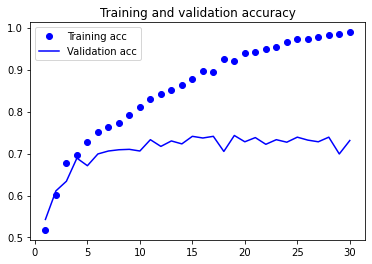

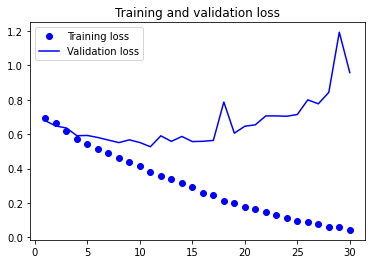

In [23]:
#훈련의 정확도와 손실 그래프 그리기

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#과대적합의 특성 보여줌

#### 5.2.5 데이터 증식 사용하기

기존 훈련 샘플로부터 더 많은 훈련 데이터 생성하는 방법

In [24]:
#ImageDataCenerator 사용해 데이터 증식 설정하기

datagen = ImageDataGenerator(rotation_range=20, #랜덤하게 사진 회전시킬 각도 범위(0~180)
                            width_shift_range=0.1, #사진을 수평/수직으로 랜덤하게 평행 이동시킬 범위(전체 높이,너비에 대한 비율)
                            height_shift_range=0.1,
                            shear_range=0.1, #랜덤하게 전단 변환 적용할 각도 범위
                            zoom_range=0.1, #랜덤하게 사진 확대할 범위
                            horizontal_flip=True, #랜덤하게 이미지 수평 뒤집기
                            fill_mode='nearest') #회전, 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀 채울 전략

In [25]:
#드롭아웃을 포함한 새로운 컨브넷 정의하기

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

In [ ]:
#데이터 증식 제너레이터 사용해 컨브넷 훈련하기

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255) #검증데이터는 증식되면 안됨

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150,150),
                                                   batch_size=32,
                                                   class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       target_size=(150,150),
                                                       batch_size=32,
                                                       class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

#모델 저장
model.save('cats_and_dogs_small_2.h5')

#### 5.3 사전 훈련된 컨브넷 사용하기

대규모 이미지 분류 문제 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크

사전 훈련된 네트워크 사용하는 방법
1. 특성 추출
2. 미세 조정


#### 5.3.1 특성 추출

사전에 학습된 네트워크 표현 사용해 새로운 샘플에서 흥미로운 특성 뽑아내는 것   
특성 사용해 새로운 분류기 처음부터 훈련

연속된 합성곱, 풀링 층으로 시작해 완전 연결 분류기로 끝남

합성곱 층만 재사용, 완전 연결 분류기는 일반적으로 재사용 X

특성 합성곱 층에서 추출한 표현의 일반성(과 재사용성) 수준은 모델에 있는 층의 깊이에 달려 있음   
모델의 하위 층은 (에지, 색, 질감 등) 지역적, 매우 일반적 특성 맵 추출함   
상위 층은 ('강아지 눈', '고양이 귀' 등) 추상적인 개념 추출   
-> 모델의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋음

In [ ]:
#VGG16 합성곱 기반 층 만들기

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', #모델 초기화할 가중치 체크포인트 지정
                 include_top=False, #네트워크 최상위 완전 연결 분류기 포함 여부 지정(기본값은 포함)
                 input_shape=(150,150,3)) #네트워크에 주입할 이미지 텐서의 크기, 선택 사항(지정 안하면 어떤 크기의 입력도 처리 가능)


**데이터 증식 사용하지 않는 빠른 특성 추출**   

빠르고 비용 적게 듬, 데이터 증식 사용 불가능


In [ ]:
#사전 훈련된 합성곱 기반 층 사용한 특성 추출하기

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20


def extract_features(directory, sample_count):
    features = np.zeros(shape =(sample_count, 4,4,512))
    labels=np.zeros(shape=(sample_count))
    generator=datagen.flow_from_directory(directory,
                                         target_size=(150,150),
                                         batch_size=batch_size,
                                         class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1) * batch_size] = features_batch
        labels[i*batch_size : (i+1) * batch_size] = labels_batch
        i+=1
        if i * batch_size >=sample_count:
            break
            #제너레이터는 루프 안에서 무한하게 데이터 만들어 내서 모든 이미지 한 번씩 처리 후에는 중지함
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

#추출된 특성의 크기는 (samples, 4, 4, 512)
#완전 연결 분ㄹ기에 주입하기 위해 먼저 (samples, 8192) 크기로 펼침

train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [ ]:
#완전 연결 분류기를 정의하고 훈련하기

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation ='relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs = 30,
                   batch_size=20,
                   validation_data = (validation_features, validation_labels))

#2개의 Dense 층만 처리하면 돼서 훈련이 매우 빠름

**데이터 증식을 사용한 특성 추출**

훨씬 느리고 비용 많이 들지만 훈련하는 동안 데이터 증식 기법 사용 가능   
conv_base 모델 확정, 입력 데이터 사용해 엔드-투-엔드로 실행

In [ ]:
#합성곱 기반 층 위에 완전 연결 분류기 추가하기

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

모델 컴파일하고 훈련 전에 합성곱 기반 층 **동결**하는 것이 아주 중요   
하나 이상의 층 **동결** 한다는 것: 훈련하는 동안 가중치 업데이트되지 않도록 막는다는 뜻

케라스에서는 trainable 속성을 False로 설정해 네트워크 동결 가능함

컴파일 단계 후에 trainable 속성 변경하면 반드시 모델 다시 컴파일해야함 (안하면 변경 사항 적용 x)

In [ ]:
#합성곱 기반 층 위에 완전 연결 분류기 추가하기

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
conv_base.trainable = False
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()



In [ ]:
#동결된 합성곱 기반 층과 함께 모델을 엔드-투-엔드로 훈련하기
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

#### 5.3.2 미세 조정

미세 조정: 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해체하고 모델에 새로 추가한 층과 함께 훈련하는 것

네트워크를 미세 조정하는 단계
1. 사전 훈련된 기반 네트워크 위에 새로운 네트워크 추가
2. 기반 네트워크 동결
3. 새로 추가한 네트워크 훈련
4. 기반 네트워크에서 일부 층의 동결 해제
5. 동결 해제한 층과 새로 추가한 층 함께 훈련

1~3단계는 특성 추출 할 때 이미 완료함

고려 사항
- 하위 층으로 갈수록 미세 조정에 대한 효과가 감소함   
        합성곱 기반 층에 있는 하위 층들은 더 일반적이고 재사용 가능한 특성들 인코딩 / 사우이 층은 더 특화된 특성 인코딩
- 훈련해야 할 파라미터가 많을수록 과대적합 위험이 커짐        

In [ ]:
#특정 층까지 모든 층 동결하기

conv_base.trainable=True

set_trainable=False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
#모델 미세 조정하기

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-5),
             metrics=['acc'])

history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=100,
                             validation_data=validation_generator,
                             validation_steps=50)

In [ ]:
#테스트 데이터에서 모델 평가

test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size(150,150),
                                                 batch_size=20,
                                                 class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc: ', test_acc)

## 5.4 컨브넷 학습 시각화

컨브넷의 표현은 시각적인 개념을 학습한 것이어서 시각화하기 아주 좋음   

세 가지 기법
- 컨브넷 중간층의 출력(중간층에 있는 활성화)을 시각화하기   
        연속된 컨브넷 층이 입력 어떻게 변형시키는지 이해, 개별적 컨브넷 필터의 의미 파악에 도움이 됨
- 컨브넷 필터를 시각화하기
        컨브넷의 필터가 찾으려는 시각적 패턴과 개념 무엇인지 상세하게 이해하는 데 도움이 됨
- 클래스 활성화에 대한 히트맵을 이미지에 시각화
        이미지의 어느 부분이 주어진 클래스에 속하는 데 기여했는지 이해, 이미지에서 객체 위치 추정에 도움이 됨
        

#### 5.4.1 중간층의 활성화 시각화하기

어떤 입력 주어졌을 때 네트워크에 있는 여러 합성곱과 풀링 층이 출력하는 특성 맵 그리는 것   
층의 출력이 활성화 함수의 출력이라 종종 **활성화**라고 부름

너비, 높이, 깊이(채널) 3개의 차원에 대해 특성 맵을 시각화하는 것이 좋음

In [ ]:
#5.2절에서 저장했던 모델 로드해서 시작

from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

In [ ]:
#개별 이미지 전처리하기

img_path = './datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) #이미지를 4D 텐서로 변경
img_tensor /= 255. #모델이 훈련될 때 입력에 적용한 전처리 방식을 동일하게 사용

print(img_tensor.shape)

In [ ]:
#테스트 사진 출력하기

import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

이미지 배치를 입력받아 모든 합성곱과 풀링 층의 활성화를 출력하는 케라스 모델 만들 것   
케라스의 Model 클래스를 사용   
입력 텐서, 출력 텐서 2개의 매개변수가 필요함   
Model 클래스를 사용하면 Sequential과는 달리 여러 개의 출력 가진 모델 만들 수 있음

In [ ]:
#입력 텐서와 출력 텐서의 리스트로 모델 객체 만들기

from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] #상위 8개 층의 출력을 추출
activation_model = models.Model(inputs=model.input, outputs=layer_outptus) #입력에 대해 8개 층의 출력 반환하는 모델

#하나의 입력과 층의 활성화마다 하나씩 총 8개의 출력을 가짐

#예측 모드로 모델 실행
activations = activation_model.predict(img_tensor) #층의 활성화마다 하나씩 8개의 넘파이 배열로 이루어진 리스트 반환

#32개의 채널 가진 148x148 크기의 특성 맵
#원본 모델의 첫 번째 층 활성화 중 20번째 채널 시각화하기
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0,:,:,19], cmap='viridis')
#대각선 에지 감지하도록 인코딩된 것 같음

#16번째 채널 시각화
plt.matshow(first_layer_activation[0,:,:,15], cmap='viridis')
#밝은 녹색 점 감지하도록 인코딩된 것 같음

In [ ]:
#중간층의 모든 활성화에 있는 채널 시각화하기

layer_names=[]
for layer in model.layers[:8]:
    layer_names.append(layer.name) #층의 이름을 그래프 제목으로 사용
    
images_per_row =16

for layer_name, layer_activation in zip(layer_names, activations): #특성 맵을 그림
    n_features = layer_activation.shape[-1] #특정 맵에 있는 특성의 수
    
    size = layer_activation.shape[1] #특성 맵의 크기는 (1, size, size, n_features)
    
    n_cols = n_features // images_per_row #활성화 채널 위한 그리드 크기 구함
    display_grid = np.zeros((size*n_cols, images_per_row * size))
    
    for col in range(n_cols): #각 활성화를 하나의 큰 그리드에 채움
        for row in range(images_per_row):
            channel_iamge = layer_activation[0, :,:, col*images_per_row+row]
            channel_imgae -= channel_image.mean() #그래프로 나타내기 좋게 특성을 처리함
            channel_image *=64
            channel_image +=128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size : (col+1) *size,
                        row*size : (row+1) * size] = channel)image #그리드를 출력함
            
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale *display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect = 'auto', cmap='viridis')

plt.show()        

- 첫 번째 층은 여러 종류의 에지 감지기 모아 놓은 것 같음
        이 단계의 활성화에는 초기 사진에 있는 거의 모든 정보가 유지됨
- 상위 층으로 갈수록 활성화는 점점 더 추상적으로 되고 시각적으로 이해하기 어려워짐
        고수준 개념(고양이 귀) 인코딩하기 시작함    
        이미지 클래스에 관한 정보가 증가함
- 비어 있는 활성화가 층이 깊어짐에 따라 늘어남
        층을 올라가면서 활성화되지 않는 필터들이 생김   
        필터에 인코딩된 패턴이 입력 이미지에 나타나지 않았다는 것을 의미함
        
심층 신경망은 입력되는 원본 데이터에 대한 정보 정제 파이프라인처럼 작동함   
반복적인 변환을 통해 관계없는 정보를 걸러 내고 유용한 정보는 강조되고 개선됨 ( 여기에서는 이미지의 클래스 )

#### 5.4.2 컨브넷 필터 시각화하기

각 필터가 반응하는 시각적 패턴 그려보기   
빈 입력 이미지에서 시작해 특정 필터의 응답 최대화하기 위해 컨브넷 입력 이미지에 경사 상승법을 적용함

전체 과정
- 특정 합성곱 층의 한 필터 값을 최대화하는 손실 함수 정의
- 활성화 값 최대화하기 위해 입력 이미지 변경하도록 확률적 경사 상승법 사용
        경사 상승법 구현 위해 모델의 입력에 대한 손실의 그래디언트가 필요함

In [ ]:
#필터 시각화를 위한 손실 텐서 정의

from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights = 'imagenet',
             include_top = False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index])

#입력에 대한 손실의 그래디언트 구하기
grads = K.gradients(loss, model.input)[0] #gradient 함수가 반환하는 텐서 리스트에서 첫 번째 텐서를 추출함
                                          #여기서는 크기가 1인 리스트
    
#경사 상승법 과정 부드럽게 하기 위해 사용하는 기법
#그래디언트 텐서를 L2 노름(텐서에 있는 값을 제곱한 합의 제곱근)으로 나눠 정규화하는 것
#입력 이미지에 적용할 수정량 크기를 항상 일정 범위


#그래디언트 정규화하기
grads /= (K.sqrt(K.mean(K.square(grads)))+1e-5) #0 나눗셈 방지 위해 1e-5를 더함



In [ ]:
#주어진 입력 이미지에 대한 손실 텐서와 그래디언트 텐서 계산하기

#입력 값에 대한 넘파이 출력 값 추출하기

iterate = K.function([model.input], [loss, grads])
#넘파이 텐서(크기 1인 텐서의 리스트)를 입력으로 받아 손실과 그래디언트 2개의 넘파이 텐서를 반환함

import numpy as np
loss_value, grads_value = iterate([np.zeros((1,150,150,3))])

#파이썬 루프를 만들어 확률적 경사 상승법 구성

input_img_data = np.random.random((1,150,150,3)) * 20 + 128.  #잡음 섞인 회색 이미지로 시작

step = 1. #업데이트할 그래디언트의 크기
#경사상승법 40회 실행
for i in range(40):
    loss_value, grads_value = iterate([input_img_data]) #손실과 그래디언트를 계산
    input_img_data += grads_value*step #손실 최대화하는 방향으로 입력 이미지를 수정

In [ ]:
#텐서를 이미지 형태로 변환하기 위한 유틸리티 함수

def deprocess_image(x):
    #텐서의 평균이 0, 표준 편차가 0.1이 되도록 정규화
    x-= x.mean()
    x/= (x.std() + 1e-5)
    x*= 0.1
    
    #[0,1]로 클리핑함
    x+= 0.5
    x = np.clip(x,0,1)
    
    #RGB 배열로 변환
    x*=255
    x=np.clip(x,0,255).astype('uint8')
    return x

In [ ]:
#필터 시각화 이미지를 만드는 함수
#층의 이름, 필터 번호를 입력으로 받아 필터 활성화를 최대화하는 패턴을 이미지 텐서로 출력함

def generate_pattern(layer_name, filter_index, size=150):
    #주어진 층과 필터의 활성화를 최대화하기 위한 손실 함수를 정의함
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    grads = K.gradients(loss, model.input)[0] #손실에 대한 입력 이미지의 그래디언트 계산
    
    grads/= (K.sqrt(K.mean(K.square(grads)))+1e-5) #그래디언트 정규화
    
    iterate = K.function([model.input],[loss,grads]) #입력 이미지에 대한 손실, 그래디언트 반환
    
    input_img_data = np.random.random((1,size,size,3))*20+128 #잡음 섞인 회색 이미지로 시작
    
    step = 1.
    #경사 상승법을 40단계 실행
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data +=grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block3_con1',0))

In [ ]:
#층에 있는 각 필터에 반응하는 패턴 생성하기

layer_name = 'block_conv1'
size = 64
margin = 5

results = np.zeros((8*size+7*margin, 8*size+margin, 3), dtype = 'uint8') #결과를 담을 빈(검은) 이미지

for i in range(8): #result 그리드의 행 반복
    for j in range(8): #result 그리드의 열 반복
        filter_img = generate_pattern(layer_name, i+(J*8), size=size) #layer_name에 있는 i+(j*8)번째 필터에 대한 패턴 생성
        #results 그리드의 (i,j)번째 위치에 저장
        horizontal_start = i*size+i*margin
        horizontal_end = horizontal_start + size
        vertical_start = j*size+J*margin
        vertical_end = vertical_start+size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
        
#result 그리드를 그림        
plt.figure(figsize = (20,20))
plt.imshow(results)

컨브넷 필터들은 모델의 상위 층으로 갈수록 점점 더 복잡해지고 개선됨
- 모델에 있는 첫 번째 층(block1_conv1)의 필터는 간단한 대각선 방향의 에지와 색 인코딩함
- block2_conv1의 필터는 에지나 색깔의 조합으로 만들어진 간단한 질감 인코딩함
- 더 상위 층의 필터는 깃털, 눈, 나뭇잎 등 자연적인 이미지에서 찾을 수 있는 질감 닮아 가기 시작함

#### 5.4.3 클래스 활성화의 히트맵 시각화하기

클래스 활성화 맵(Class Activation Map, CAM) 시각화
- 이미지의 어느 부분이 컨브넷의 최종 분류 결정에 기여하는지 이해하는 데에 유용함
- 분류에 실수가 있는 경우 컨브넷 결정 과정을 디버깅 하는 데 도움이 됨
- 이미지에 특정 물체가 있는 위치를 파악하는 데 사용할 수도 있음

입력 이미지에 대한 클래스 활성화의 히트맵을 만듬   
클래스 활성화 히트맵은 특정 출력 클래스에 대해 입력 이미지의 모든 위치 계산한 2D 점수 그리드

구현하는 방법
1. 입력 이미지 주어지면 합성곱 층에 있는 특성 맵의 출력 추출
2. 특성 맵의 모든 채널 출력에 채널에 대한 클래스의 그래디언트 평균을 곱함   
        '입력 이미지가 각 채널을 활성화하는 정도'에 대한 공간적인 맵을 '클래스에 대한 각 채널의 중요도'로 가중치를 부여해 
        '입력 이미지가 클래스를 활성화하는 정도'에 대한 공간적인 맵 만드는 것

In [ ]:
#사전 훈련된 가중치로 VGG16 네트워크 로드하기

from keras.applications.vgg16 import VGG16

model = VGG16(weights = 'imagenet') #이전 모든 예제에서는 최상단의 완전연결분류기 제외했지만 여기서는 아님

In [ ]:
#VGG16을 위해 입력 이미지 전처리하기
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

imp_path = './datasets/creative_commons_elephant.jpg' #이미지 경로

img = image.load_img(img_path, target_size=(224,224)) #224x224 크기의 파이썬 이미징 라이브러리(PIL) 객체로 반환됨

x = image.img_to_array(img) #(224,224,3) 크기의 넘파이 float32 배열
x = np.expand_dims(x,axis=0) #차원을 추가해 (1,224,224,3) 크기의 배치로 배열 변환함

x = preprocess_input(x) #데이터를 전처리함(채널별 컬러 정규화를 수행함)

In [ ]:
#이 이미지에서 사전 훈련된 네트워크 실행하고 예측 벡터 이해하기 쉽게 디코딩함

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

이미지에 대한 상위 3개의 예측 클래스
- 아프리카 코끼리(92.5% 확률)
- 코끼리(7% 확률)
- 인도 코끼리(0.4% 확률)

예측 벡터에서 최대 활성화된 항목은 '아프리카 코끼리' 클래스에 대한 것으로 386번 인덱스

In [ ]:
#이미지에서 가장 아프리카 코끼리 같은 부위 시각화 위해 Grad-CAM 처리 과정 구현
#Grad-CAM 알고리즘 설정하기

african_elephant_output = model.output[:,386] #예측 벡터의 '아프리카 코끼리' 항목

last_conv_layer = model.get_layer('block5_conv3') #VGG16의 마지막 합성곱 층인 block5_conv3 층의 특성 맵

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0] 
#block5_conv3의 특정 맵 출력에 대한 '아프리카 코끼리' 클래스의 그래디언트

pooled_grads = K.maen(grads, axis=(0,1,2)) #특성 맵 채널별 그래디언트 평균값 담긴 (512, ) 크기의 벡터

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
#샘플 이미지 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구함

pooled_grads_value, conv_layer_output_value = iterate([x])
#두 마리 코끼리가 있는 샘플 이미지 주입하고 2개의 넘파이 배열 얻음

#아프리카 코끼리 클래스에 대한 '채널의 중요도'를 특성 맵 배열의 채널에 곱함
for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis =-1) #만들어진 특성 맵에서 채널 축 따라 평균한 값이 클래스 활성화의 히트맵

In [ ]:
#히트맵 후처리하기 (0과 1 사이로 정규화)

heatmap=np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [ ]:
#원본 이미지에 히트맵 덧붙이기(OpenCV 사용해서)

import cv2

img = cv2.imread(img_path) #cv2 모듈 사용해 원본 이미지 로드

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) #heatmap을 원본 이미지 크기에 맞게 변경함
heatmap = np.uint8(255*heatmap) #heatmap을 RGB 포맷으로 변환함
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) #히트맵으로 변환함

superimposed_img = heatmap * 0.4 + img #0.4는 히트맵의 강도

cv2.imwrite('./datesets/elephant_cam.jpg', superimposed_img) #디스크에 이미지 저장

시각화 기법이 주는 답
- 왜 네터워크가 이 이미지에 아프리카 코끼리가 있다고 생각?
- 아프리카 코끼리가 사진 어디에 있는가?